In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from numpy import exp
from scipy import ndimage
from func import *
from matplotlib.colors import LogNorm
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
kernel = Gaussian2DKernel(x_stddev=1)
from scipy.optimize import least_squares

In [22]:
def spectroastrometry(z,mini_cube,mini_err,mini_wave,MC_loops):
    k = 1+z
    c = 300000
    central_vel = c*z
    output_par = np.zeros((14,mini_cube.shape[1],mini_cube.shape[2]),dtype=np.float32)
    output_par_err = np.zeros((14,mini_cube.shape[1],mini_cube.shape[2]),dtype=np.float32)
    fitted = np.zeros((np.shape(mini_wave)[0],mini_cube.shape[1],mini_cube.shape[2]),dtype=np.float32)
    wing_fitted = np.zeros((np.shape(mini_wave)[0],mini_cube.shape[1],mini_cube.shape[2]),dtype=np.float32)
    residual = np.zeros((np.shape(mini_wave)[0],mini_cube.shape[1],mini_cube.shape[2]),dtype=np.float32)
    for i in range(mini_cube.shape[1]):
        for j in range(mini_cube.shape[2]):
            print (i,j)
            (spectrum,error) = (mini_cube[:,i,j],mini_err[:,i,j])   
            lower_bounds = [0,0,0,0,central_vel - 1000,0,0,0,0,0,central_vel - 1000,0,-np.inf,-np.inf]
            upper_bounds = [np.inf,np.inf,np.inf,np.inf,central_vel + 1000,200,np.inf,np.inf,np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf]
            bounds_p_init = (lower_bounds,upper_bounds) 
            try:
                result = least_squares(Type2_gauss_coupled,x0=[300,100,10,10,6516,100,30,10,1,1,6416,200,-0.001,2.0],bounds=bounds_p_init,args=(mini_wave,spectrum,error),max_nfev = 10000000)
                popt_full_fit = result['x']  
            except RuntimeError or RuntimeWarning:
                popt_full_fit = [1e-5,1e-5,1e-5,1e-5,central_vel,1e-5,1e-5,1e-5,1e-5,1e-5,central_vel,1e-5,0.0001,0.01]
            spec_parameters_MC = np.zeros((len(popt_full_fit),MC_loops))
            for l in range(MC_loops):
                iteration_data = np.random.normal(spectrum,error)   
                try:
                    result_MC = least_squares(Type2_gauss_coupled,x0=[300,100,10,10,6516,100,30,10,1,1,6416,200,-0.001,2.0],args=(mini_wave,iteration_data,error),max_nfev = 10000000)    
                    popt_spec_MC = result_MC['x']
                except RuntimeError or RuntimeWarning:
                    popt_spec_MC = [1e-5,1e-5,1e-5,1e-5,central_vel,1e-5,1e-5,1e-5,1e-5,1e-5,central_vel,1e-5,0.0001,0.01]
                spec_parameters_MC[:,l]=popt_spec_MC
            spec_parameters_err = np.std(spec_parameters_MC,1)
            output_par_err[:,i,j] = spec_parameters_err
           
            output_par[:,i,j]=popt_full_fit
            fitted[:,i,j]=(Type2_gauss_coupled(popt_full_fit,mini_wave,spectrum,error))*(error)+spectrum 
            residual[:,i,j] = mini_cube[:,i,j] - fitted[:,i,j]
            output_par_err[:,i,j] = spec_parameters_err
    return output_par,output_par_err,wing_fitted,fitted,residual

def flux_map(output_par,obj,destination_path_cube="/media/rickeythecat/Seagate/3C264/MUSE"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(output_par[0,:,:],name='amp_Ha'))
    hdus.append(fits.ImageHDU(output_par[1,:,:],name='amp_NII6583'))
    hdus.append(fits.ImageHDU(output_par[2,:,:],name='amp_SII6716'))
    hdus.append(fits.ImageHDU(output_par[3,:,:],name='amp_SII6731'))
    hdus.append(fits.ImageHDU(output_par[4,:,:],name='vel_Ha'))
    hdus.append(fits.ImageHDU(output_par[5,:,:],name='vel_sigma_ha'))
    hdus.append(fits.ImageHDU(output_par[6,:,:],name='amp_Ha_br'))
    hdus.append(fits.ImageHDU(output_par[7,:,:],name='amp_NII6583_br'))
    hdus.append(fits.ImageHDU(output_par[8,:,:],name='amp_SII6716_br'))
    hdus.append(fits.ImageHDU(output_par[9,:,:],name='amp_SII6731_br'))
    hdus.append(fits.ImageHDU(output_par[10,:,:],name='vel_Ha_br'))
    hdus.append(fits.ImageHDU(output_par[11,:,:],name='vel_sigma_Ha_br'))
    hdus.append(fits.ImageHDU(output_par[12,:,:],name='m'))
    hdus.append(fits.ImageHDU(output_par[13,:,:],name='c'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/elinecube_par_%s.fits'%(destination_path_cube,obj),overwrite='True')

def flux_map_err(output_par_err,obj,destination_path_cube="/media/rickeythecat/Seagate/3C264/MUSE"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(output_par_err[0,:,:],name='amp_Ha_err'))
    hdus.append(fits.ImageHDU(output_par_err[1,:,:],name='amp_NII6583_err'))
    hdus.append(fits.ImageHDU(output_par_err[2,:,:],name='amp_SII6716_err'))
    hdus.append(fits.ImageHDU(output_par_err[3,:,:],name='amp_SII6731_err'))
    hdus.append(fits.ImageHDU(output_par_err[4,:,:],name='vel_Ha_err'))
    hdus.append(fits.ImageHDU(output_par_err[5,:,:],name='vel_sigma_Ha_err'))
    hdus.append(fits.ImageHDU(output_par_err[6,:,:],name='amp_Ha_br_err'))
    hdus.append(fits.ImageHDU(output_par_err[7,:,:],name='amp_NII6583_br_err'))
    hdus.append(fits.ImageHDU(output_par_err[8,:,:],name='amp_SII6716_br_err'))
    hdus.append(fits.ImageHDU(output_par_err[9,:,:],name='amp_SII6731_br_err'))
    hdus.append(fits.ImageHDU(output_par_err[10,:,:],name='vel_Ha_br_err'))
    hdus.append(fits.ImageHDU(output_par_err[11,:,:],name='vel_sigma_Ha_br_err'))
    hdus.append(fits.ImageHDU(output_par_err[12,:,:],name='m_err'))
    hdus.append(fits.ImageHDU(output_par_err[13,:,:],name='c_err'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/elinecube_par_err_%s.fits'%(destination_path_cube,obj),overwrite='True')


In [23]:
def spectroastrometric_script(obj,z,MC_loops=0,destination_path_cube="/media/rickeythecat/Seagate/3C264/MUSE"):
    (mini_cube,mini_err,mini_wave,mini_header) = loadCube('%s/%s.9_arcsec_elinecube.fits'%(destination_path_cube,obj))
    (output_par,output_par_err,wing_cube,fitted_cube,residual_cube) = spectroastrometry(z,mini_cube,mini_err,mini_wave,MC_loops)
    store_cube('%s/%s.fitted_residual_elinecube.fits'%(destination_path_cube,obj),fitted_cube,mini_wave,residual_cube,mini_header)    
    flux_map(output_par,obj)
    flux_map_err(output_par_err,obj)    
    print ('%s.fits'%(obj))

In [24]:
z = {"3C264":0.02172}

objs = z.keys()

for obj in objs:
    spectroastrometric_script(obj,z[obj])

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29


33 13
33 14
33 15
33 16
33 17
33 18
33 19
33 20
33 21
33 22
33 23
33 24
33 25
33 26
33 27
33 28
33 29
33 30
33 31
33 32
33 33
33 34
33 35
33 36
33 37
33 38
33 39
33 40
33 41
33 42
33 43
33 44
34 0
34 1
34 2
34 3
34 4
34 5
34 6
34 7
34 8
34 9
34 10
34 11
34 12
34 13
34 14
34 15
34 16
34 17
34 18
34 19
34 20
34 21
34 22
34 23
34 24
34 25
34 26
34 27
34 28
34 29
34 30
34 31
34 32
34 33
34 34
34 35
34 36
34 37
34 38
34 39
34 40
34 41
34 42
34 43
34 44
35 0
35 1
35 2
35 3
35 4
35 5
35 6
35 7
35 8
35 9
35 10
35 11
35 12
35 13
35 14
35 15
35 16
35 17
35 18
35 19
35 20
35 21
35 22
35 23
35 24
35 25
35 26
35 27
35 28
35 29
35 30
35 31
35 32
35 33
35 34
35 35
35 36
35 37
35 38
35 39
35 40
35 41
35 42
35 43
35 44
36 0
36 1
36 2
36 3
36 4
36 5
36 6
36 7
36 8
36 9
36 10
36 11
36 12
36 13
36 14
36 15
36 16
36 17
36 18
36 19
36 20
36 21
36 22
36 23
36 24
36 25
36 26
36 27
36 28
36 29
36 30
36 31
36 32
36 33
36 34
36 35
36 36
36 37
36 38
36 39
36 40
36 41
36 42
36 43
36 44
37 0
37 1
37 2
37 3
37 4
37 

In [2]:
hdu = fits.open('/media/rickeythecat/Seagate/3C264/MUSE/elinecube_par_3C264.fits')
vel_Ha = hdu[5].data
amp_Ha_br = hdu[7].data
amp_NII_br = hdu[8].data
amp_SII6716_br = hdu[9].data
amp_SII6731_br = hdu[10].data
vel_Ha_br = hdu[11].data
vel_sigma_Ha_br = hdu[12].data
hdu.close()

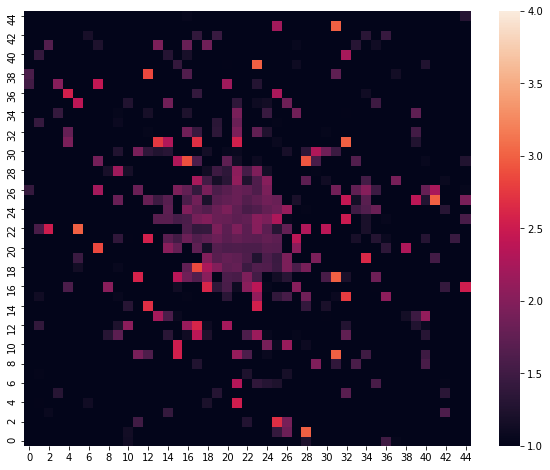

In [35]:
import seaborn as sns
fig = plt.figure(figsize=(10,8))
vel_sigma_Ha_br[vel_sigma_Ha_br==600]=0

ax = sns.heatmap(vel_sigma_Ha_br/200,vmin=1,vmax=4)
ax.set
ax.invert_yaxis()

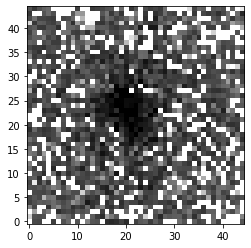

In [28]:
plt.imshow(amp_Ha_br,origin='lower',vmin=0.1,cmap='binary',vmax=100,norm=LogNorm())

In [14]:
import seaborn as sns

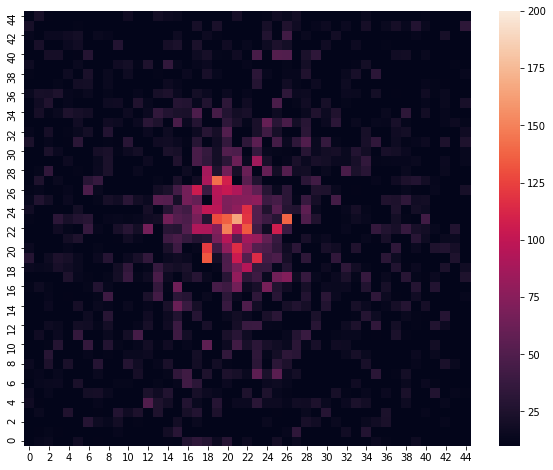

In [17]:
fig=plt.figure(figsize=(10,8))
amp_Ha_br[amp_Ha_br>200] = 10
ax = sns.heatmap(amp_Ha_br,vmin=10,vmax=200)
ax.set
ax.invert_yaxis()

In [3]:
v_out = vel_Ha_br - vel_Ha

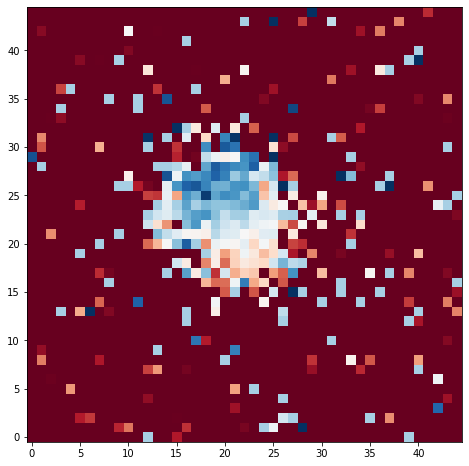

In [30]:
fig=plt.figure(figsize=(10,8))
v_out[v_out>200] = 0
v_out[v_out<-1000] = 0
plt.imshow(v_out,origin='lower',vmin=-200,vmax=100,interpolation='nearest',cmap='RdBu')